### This is a server based version of a famous classifier

In [1]:
#import all we need
import glob #for file handeling
import matplotlib.pyplot as plt #for show images
import numpy as np #for some vector arithmatic

#section making dataset
import shutil #for file handeling
import os #for file management

#section pytorch
import torch
import torch.nn as nn #neural net module

from torchvision.datasets import ImageFolder #dataset handeling
from torchvision import transforms as tf #make transformation
from torch.utils.data import DataLoader as DL #dataset handeling
import torchvision.models as ml #torch models such as ResNet
from torch.autograd import Variable #handle some non-tensor inputs from dataset
from torchsummary import summary #show network summary


#section evaluate
import time #for mesauring time

#image handeling
from PIL import Image

#need for some randomization
import random

In [2]:
path = 'dataset/Train_Data' #main folder of training dataset

dog_files = [f for f in glob.glob('dataset/Train_Data/dog/*.jpg')] #read all files in dog folder
cat_files = [f for f in glob.glob('dataset/Train_Data/cat/*.jpg')] #read all files in cat folder
files = dog_files + cat_files #make all files

print(f'Total no of images {len(files)}')

Total no of images 1399


In [3]:
no_of_images = len(files)
shuffle = np.random.permutation(no_of_images)
print(shuffle.size)

1399


In [5]:
split_ratio = 0.8
train_size = int(np.ceil(no_of_images * 0.8))
val_size = int(np.ceil(no_of_images * 0.1))
test_size = no_of_images - val_size - train_size
print(train_size)
print(val_size)
print(test_size)
print(train_size+val_size+test_size)

folders = ['train/','test/','valid/']
tz = ['dog/','cat/']

for f in folders:
    for t in tz:
        dist = os.path.join(path,f,t)
        os.makedirs(dist,exist_ok=True)

1120
140
139
1399


In [6]:
for i in shuffle[:val_size]:
    folder = files[i].split('/')[-2].split('.')[0]
    image = files[i].split('/')[-1]
    dis_path = os.path.join(path,'valid/',folder)
    shutil.copy(files[i],dis_path)
    
for i in shuffle[val_size:test_size+val_size]:
    folder = files[i].split('/')[-2].split('.')[0]
    image = files[i].split('/')[-1]
    dis_path = os.path.join(path,'test/',folder)
    shutil.copy(files[i],dis_path)
    
for i in shuffle[test_size+val_size:]:
    folder = files[i].split('/')[-2].split('.')[0]
    image = files[i].split('/')[-1]
    dis_path = os.path.join(path,'train/',folder)
    shutil.copy(files[i],dis_path)

In [3]:
cat_files = [f for f in glob.glob('dataset/Train_Data/cat/*.jpg')]
dog_files = [f for f in glob.glob('dataset/Train_Data/dog/*.jpg')]
files = dog_files + cat_files
#files = np.array(files)

mean_tensor = torch.tensor([0,0,0])
std_tensor = torch.tensor([0,0,0])
transform = tf.Compose([tf.Resize((225,225)),
                       tf.ToTensor()])

for i,image in enumerate(files):
    im = Image.open(image)
    tim = transform(im)
    mean_tensor = mean_tensor + torch.mean(tim, dim=[1,2])
    std_tensor = std_tensor + tim.std([1,2])
    
print(mean_tensor/(i+1))
print(std_tensor/(i+1))

tensor([0.4858, 0.4515, 0.4124])
tensor([0.2245, 0.2182, 0.2181])


In this section we make a transform function. First of all, we resize all images to 225x225 and then convert them to tensors. Finall we normalize images.

In [4]:
transform = tf.Compose([tf.Resize((225,225)),
                       tf.ToTensor(),
                       tf.Normalize([0.4858, 0.4515, 0.4124],
                                   [0.2245, 0.2182, 0.2181])
                       ])

This sectin we prepare dataset for training, testing and validation. The folders' structure is as follow:
```
dataset
│
└── Train_Data
    │
    ├── test
    │   ├── cat
    │   └── dog
    ├── tom
    │   └── cat
    ├── train
    │   ├── cat
    │   └── dog
    └── valid
        ├── cat
        └── dog
```
The tom folder is for test the algorithm ;D

In [5]:
# make ImageFolders
path = 'dataset/Train_Data' #main folder of training dataset

train_path = os.path.join(path,'train/')
val_path = os.path.join(path,'valid/')
test_path = os.path.join(path,'test/')

train = ImageFolder(train_path,transform)
val = ImageFolder(val_path,transform)
test = ImageFolder(test_path,transform)

# class_to_idx is an atrribute of ImageFolder class and return a dictionary
print(test.class_to_idx)

# classes is an atrribute of ImageFolder class and return a list of classes
print(test.classes)

# imgs is an atrribute of ImageFolder class and return a list of images
#print(test.imgs)


{'cat': 0, 'dog': 1}
['cat', 'dog']


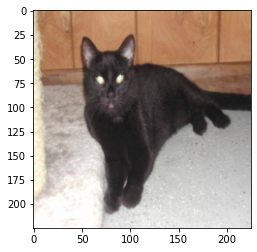

In [6]:
#this function recieve a tensor image and convert it to numpy and normalize it the show it
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))#transpose from [CxHxW] to [HxWxC]
    #normalize according to transform function
    mean = np.array([0.4858, 0.4515, 0.4124])
    std = np.array([0.2245, 0.2182, 0.2181])
    inp = std*inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)

#for testing
imshow(train[10][0])

In [7]:
train_data_generator = DL(train, shuffle=True, batch_size = 64, num_workers = 9)
val_data_generator = DL(val, shuffle=True, batch_size = 64, num_workers = 9)
test_data_generator = DL(test, shuffle=True, batch_size = 1, num_workers = 9)

In [8]:
#make a dictionary to store dataset sizes for each phase
dataset_sizes = {'train':len(train_data_generator.dataset),
                 'valid':len(val_data_generator.dataset),
                 'test':len(test_data_generator.dataset)}

#make a dictionary to store datasets for each phase
dataloaders = {'train':train_data_generator,
               'valid':val_data_generator,
               'test':test_data_generator}

In [9]:
#make model ResNet18 and pretrained
my_model = ml.resnet18(pretrained = True)

In [10]:
n_features = my_model.fc.in_features#return number of features for ResNet18
my_model.fc = nn.Linear(n_features,4)#change full conv output numbers

In [11]:
#transfer model to GPU
is_cuda = torch.cuda.is_available()
print(is_cuda)
if is_cuda:
    my_model = my_model.cuda()

True


In [12]:
# print summary of model
summary(my_model, (3, 225, 225))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 113, 113]           9,408
       BatchNorm2d-2         [-1, 64, 113, 113]             128
              ReLU-3         [-1, 64, 113, 113]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]          36,864
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
       BasicBlock-11           [-1, 64, 57, 57]               0
           Conv2d-12           [-1, 64, 57, 57]          36,864
      BatchNorm2d-13           [-1, 64, 57, 57]             128
             ReLU-14           [-1, 64,

In [13]:
# define loss function 
my_criterion = nn.CrossEntropyLoss()

In [14]:
#define optimizer
my_optimizer = torch.optim.SGD(my_model.parameters(),lr = 0.005, momentum = 0.6)

#Decays the learning rate of each parameter group by gamma
my_scheduler = torch.optim.lr_scheduler.StepLR(my_optimizer, step_size = 2, gamma = 0.05)

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    train_error = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                    

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
                
                #clear GPU memory cache
                torch.cuda.empty_cache()
            #decay learning rate    
            scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            train_error[epoch] = epoch_loss
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [16]:
my_model = train_model(my_model, my_criterion, my_optimizer, my_scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 0.0067 Acc: 0.8571
valid Loss: 0.0029 Acc: 0.9786

Epoch 1/3
----------
train Loss: 0.0024 Acc: 0.9688
valid Loss: 0.0026 Acc: 0.9786

Epoch 2/3
----------
train Loss: 0.0021 Acc: 0.9786
valid Loss: 0.0029 Acc: 0.9786

Epoch 3/3
----------
train Loss: 0.0022 Acc: 0.9741
valid Loss: 0.0026 Acc: 0.9786

Training complete in 0m 24s
Best val Acc: 0.978571


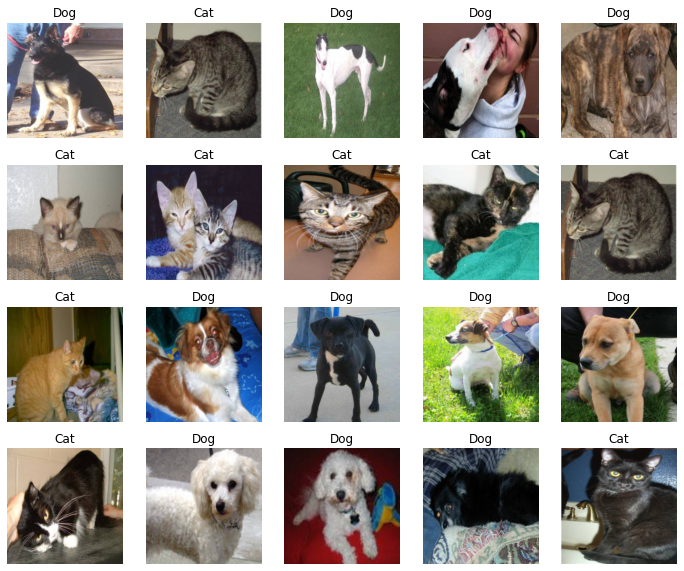

In [17]:
#test on test dataset
inp = []
lab = []
for data in dataloaders['test']:
                # get the inputs
                #print(data[1])
                inputs, labels = data
                #print(type(inputs))

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                
                inp.append(inputs)
                lab.append(labels)
                

                #outputs = my_model(inputs)
                

plt.figure(figsize=(12, 10))
for i in range(20):
    k = random.randint(1, 138)
    out = my_model(inp[k])
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    _,p = torch.max(out.data,1)
    error = my_criterion(out,lab[k])
    plt.subplot(4, 5, i+1)
    #if prediction < 0.5:
     #   plt.title('cat %.2f%%' % (100 - prediction*100))
    #else:
     #   plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    imshow(inp[k][0].cpu()) # convert BGR to RGB
    if (p[0] == torch.tensor([1]).cuda()):
        plt.title('Dog')
    else:
        plt.title('Cat')
    #plt.title(p[0].cpu().numpy())

tensor(79.0204, device='cuda:0', grad_fn=<RsubBackward1>)


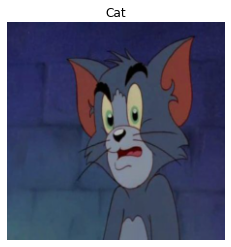

In [18]:
#test on tom picture
tom_path = os.path.join(path,'tom/')
test = ImageFolder(tom_path,transform)
tom_data_generator = DL(test, shuffle=True, batch_size = 1, num_workers = 9)
for inp,la in  tom_data_generator :
    #print(inp.shape)
    out = my_model(inp.cuda())
    #print(out.data)
    _,p = torch.max(out.data,1)
    #print(_)
    #print(p)
    loss = my_criterion(out,la.cuda()) 
    print(100 - 100*loss)
    plt.axis('off')
    imshow(inp[0])
    if (p[0] == torch.tensor([0]).cuda()):
        plt.title('Cat')

In [19]:
#find optimal number of workers
import time
pin_memory = False
print('pin_memory is', pin_memory)
 
for n_w in range(0, 20, 1): 
    train_data_generator = DL(train, shuffle=True, batch_size = 64, num_workers = n_w)
    start = time.time()
    for epoch in range(1, 5):
        for i, data in enumerate(train_data_generator):
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, n_w))

pin_memory is False
Finish with:19.643495082855225 second, num_workers=0
Finish with:21.60678482055664 second, num_workers=1
Finish with:12.239649772644043 second, num_workers=2
Finish with:8.800193548202515 second, num_workers=3
Finish with:7.414350748062134 second, num_workers=4
Finish with:6.38690185546875 second, num_workers=5
Finish with:5.256484746932983 second, num_workers=6
Finish with:5.412122964859009 second, num_workers=7
Finish with:5.421405792236328 second, num_workers=8
Finish with:4.616804599761963 second, num_workers=9
Finish with:4.433473825454712 second, num_workers=10
Finish with:4.608532667160034 second, num_workers=11
Finish with:4.702324390411377 second, num_workers=12
Finish with:4.905500411987305 second, num_workers=13
Finish with:5.0966057777404785 second, num_workers=14
Finish with:5.143062591552734 second, num_workers=15
Finish with:5.2246928215026855 second, num_workers=16
Finish with:4.754448413848877 second, num_workers=17
Finish with:4.5589516162872314 se